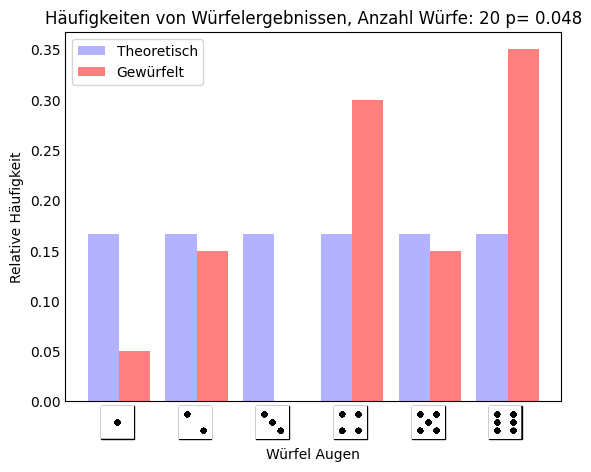

In [160]:
import matplotlib.pyplot as plt
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from scipy.stats import chisquare


STATPATH = r'C:\Users\buehl\repos\Dice\workspace\data\dicesides'

# Function to place an image on the plot
def place_image(ax, img_path, xy, zoom=1):
    # Load the image
    img = plt.imread(img_path)
    
    # Create an OffsetImage
    imagebox = OffsetImage(img, zoom=zoom)
    
    # Create an AnnotationBbox
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(10, -15), boxcoords="offset points", pad=0)
    
    # Add it to the axes
    ax.add_artist(ab)



# Theoretical distribution for a fair dice (uniform distribution)
fair_probs = [1/6] * 6  # Since each outcome (1-6) has an equal probability
# Simulating rolls for an unfair dice
outcomes = [1, 2, 3, 4, 5, 6]
weights = [10, 10, 10, 10, 10, 30]  # Example weights: 5 and 6 are three times more likely

# replace line with the IO from results
rolls = random.choices(outcomes, weights, k=20)

# Counting the frequency of each outcome for the unfair dice
unfair_probs = [rolls.count(i) / len(rolls) for i in range(1, 7)]
observed_frequencies = [rolls.count(i) for i in range(1, 7)]
expected_frequencies = [len(rolls) / 6] * 6
chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)


# Create the plot
fig, ax = plt.subplots()

# Plotting the bar charts
ax.bar(range(1, 7), fair_probs, alpha=0.3, color='blue', label='Theoretisch', width=0.4)
ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.5, color='red', label='Gewürfelt', width=0.4)

# Remove numerical x-tick labels and place images instead
ax.set_xticks(range(1, 7))
ax.set_xticklabels([])  # Remove x-tick labels
ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

for i in range(1, 7):
    place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)

# Adding title and legend
plt.title(f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}')
plt.legend()

# Adjusting the x-axis label position
plt.xlabel('Würfel Augen', labelpad=30)
plt.ylabel('Relative Häufigkeit')

# Show the plot
plt.show()
